In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import scipy.io
import stumpy

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

### code for conversation

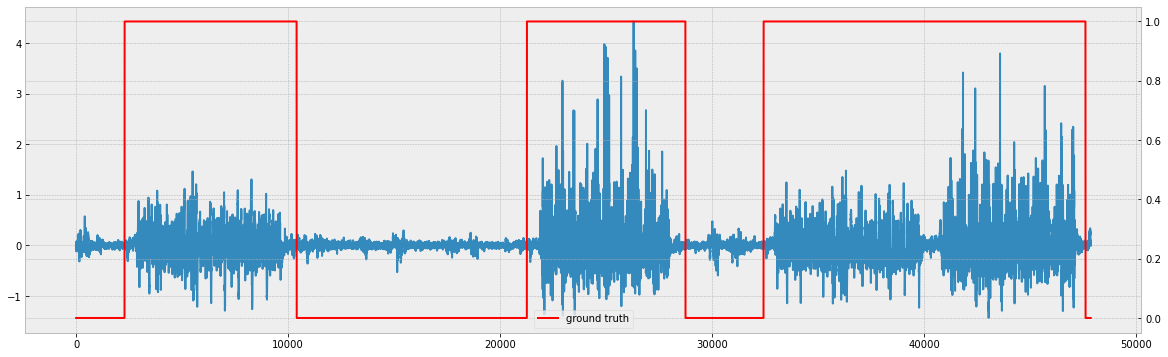

In [8]:
path = "subject101.csv"
df101 = pd.read_csv(path)

data28 = df101.iloc[152000:200000, 28].values.copy()
gt = df101.iloc[152000:200000, 2].values.copy()  # ground truth
gt2 = gt.copy()
gt2[gt2 > 1] = 1  # label is only 2 class(moving or not)

# remove nan
idx_valid = ~np.isnan(data28)
data28_ = data28[idx_valid]
gt2_ = gt2[idx_valid]

ax1 = plt.axes()
ax2 = ax1.twinx()
ax1.plot(data28_)
ax2.plot(gt2_, color="r", label="ground truth")
ax2.legend()
plt.show()

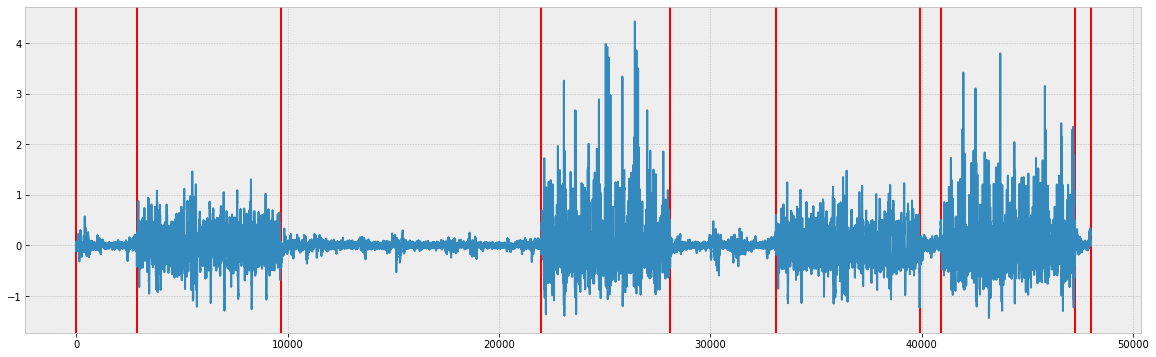

In [10]:
div = np.array([152000, 154900, 161700, 174012, 180116, 185087, 191927, 192905, 199267, 200000])  # sensitive ground truth
div = div - div[0]
for i in range(len(div)):
    plt.axvline(div[i], color="r")
plt.plot(data28)

## Policy and problem(for conversation)
- Dataset  
Pamap Dataset as main dataset is not avilable.  
Pamap2 is avilable. it is similar, but not exactly same.  
Dataset image in paper has too many points as much as image dupication doesn't work.  
=> I find similar snippert from pamap2.

- Logic  
Segmentaion is done with a simple threshould and matrix profile.  
&emsp;MP < 2/3 * (min(MP)+max(MP));  
&emsp;But it won't work with fix threshould.  
&emsp;Dataset also has ground truth can make us to search best parameter.  
&emsp;As long as searching appropriate threshould, logic works.  
No explanation for window size.  
&emsp;It also could be determinated by searching.  

- Ground truth  
As you can see above, original ground truth is insensitive to activity.  
&emsp;Maybe two patten(sensitive and insensitive) is a good reference.

## Notebook flow(for conversation)
- Original paper  
proposed methods:Hidden Markov Models  
Segmenting with matrix profile

- This notebook
explaition of segmentation  
(skip HMM sample?)  
Segmenting with matrix profile by searched parameter(window, threshould) insensitive ground truth  
Segmenting with matrix profile by searched parameter(window, threshould) sensitive ground truth  
(Bounus 1.How to search paramter? ) 

# Segmenting repetitive exercises
In recent years, there have been dozens of papers published on the task of segmenting repetitive exercises—such as weight training and calisthenics—via body worn sensors.  
See Morris et al. (2014)[1] and the references therein and thereof.  

Many of the proposed methods use **Hidden Markov Models**, a powerful technique, but one that typically requires a lot of training data and careful parameter tuning.  
The Matrix Profile and a single line of extra code can segment repetitive exercises with high accuracy.

We tested this code snippet on the Pamap Dataset (Reiss and Stricker 2012)[2], a dataset frequently used by the relevant community.  
In this notebook, we adopt successor data set (Pamap2)[3] because of data availability.  
Here is a snippet of dataset and its ground truth.

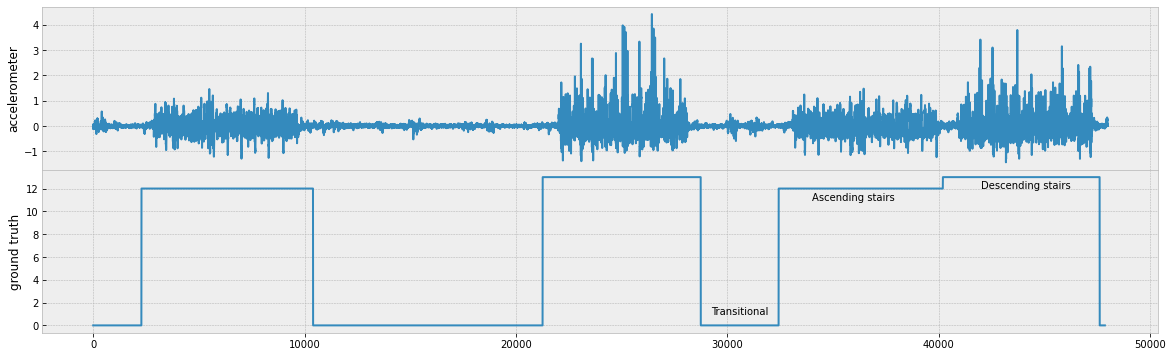

In [20]:
path = "subject101.csv"
df101 = pd.read_csv(path)
dfx = df101.iloc[152000:200000].copy()

T = dfx.iloc[:, 28].values
gt = dfx.iloc[:, 2].values

# remove nan
idx_valid = ~np.isnan(T)
T = T[idx_valid]
gt = gt[idx_valid]

fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(data28)
axs[0].set_ylabel("accelerometer")
axs[1].plot(gt)
axs[1].set_ylabel("ground truth")
axs[1].text(29250, 1, "Transitional")
axs[1].text(34000, 11, "Ascending stairs")
axs[1].text(42000, 12, "Descending stairs")
plt.show()

Ground truth(GT) segmentation has 3 activities into **ascending stairs**, **descending stairs** and **transitional sctivities**.  
The MP segmentation we predicted largely agrees, and was computed simply by thresholding the Matrix Profile.  

Our approach is following two line of code for segmentation.  
Sequencetocompute the matrix profile `T`, window size `m` and threhold value for segmentation `Th`.

$[MP, MPindex] = computeMatrixProfile(T,m)$  
$regions~~of~~repetition = MP < Th * (min(MP)+max(MP))$

As mentioned above, GT has 3 activities.  
But we segmentate in boolean vector of {**transitional** | **other (ascending stairs/descending stairs)**}.

In [39]:
m = 750
th = 0.24  # threshold value for segmentation

# ground truth convertion 3-class to 2-class
gt[gt > 0] = 1

mp = stumpy.stump(T, m, normalize=False)
TH = (max(mp[:, 0]) + min(mp[:, 0]))*th
result = mp[:, 0] > TH
correction = np.equal(result, gt[:-(m-1)])
rate_corr = sum(correction)/len(correction)
print(f"predicted segmentation agrees with it {rate_corr*100:.2f}%")

predicted segmentation agrees with it 95.25%


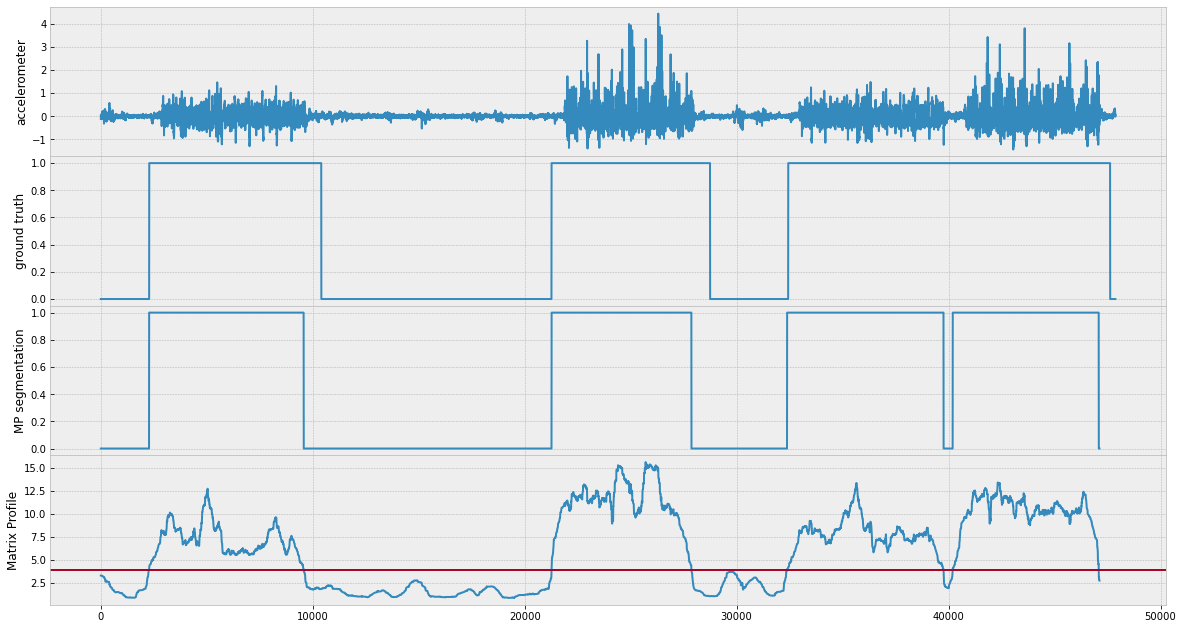

In [36]:
fig, axs = plt.subplots(4, 1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(20, 11))
axs[0].plot(T)
axs[0].set_ylabel("accelerometer")

axs[1].plot(gt)
axs[1].set_ylabel("ground truth")

axs[2].plot(result)
axs[2].set_ylabel("MP segmentation")

axs[3].plot(mp[:, 0])
axs[3].axhline(TH, color="C1", label="TH")
axs[3].set_ylabel("Matrix Profile")
plt.show()

# Reference
[1]: [a](wefw)
[2]: b